In [1]:
pip show tensorflow

Name: tensorflow
Version: 2.17.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [2]:
!python3 -m pip install --upgrade pip

In [3]:
!pip install gymnasium

In [4]:
!pip install tqdm

In [5]:
import random, time
from collections import deque, namedtuple

import gymnasium as gym
import numpy as np
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))

from tqdm.auto import tqdm

n_episodes = 150  # play 150 games
eps = 1.0  # exploration rate, probability of choosing random action
eps_decay = 0.9975  # eps gets multiplied by this number each epoch...
min_eps = 0.1  # ...until this minimum eps is reached
gamma = 0.95  # discount
max_memory_size = 10000  # size of the replay memory
batch_size = 16  # batch size of the neural network training
min_length = 160  # minimum length of the replay memory for training, before it reached this length, no gradient updates happen
memory_parts = [
    "state",
    "action",
    "next_state",
    "reward",
    "done",
]  # nice names for the part of replay memory, otherweise the names are 0-5

2024-09-29 20:37:08.621539: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-29 20:37:08.646412: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-29 20:37:08.667500: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-29 20:37:08.673050: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-29 20:37:08.694375: I tensorflow/core/platform/cpu_feature_guar

Num GPUs Available:  1
Num CPUs Available:  1


I0000 00:00:1727642230.227748   31600 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727642230.255774   31600 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727642230.255812   31600 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [6]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [29]:
!pip install gymnasium[classic-control]


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 22.4 MB/s eta 0:00:00a 0:00:01


# Learning A Model

In [7]:
Memory = namedtuple("Memory", memory_parts)  # a single entry of the memory replay


class ReplayMemory:
    def __init__(self, max_length=None):
        self.max_length = max_length
        self.memory = deque(maxlen=max_length)

    def store(self, data):
        self.memory.append(data)

    def _sample(self, k):
        return random.sample(self.memory, k)

    def structured_sample(self, k):
        batch = self._sample(k)
        result = {}
        for i, part in enumerate(memory_parts):
            result[part] = np.array([row[i] for row in batch])

        return result

    def __len__(self):
        return len(self.memory)

In [8]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(4,)),  # Define input shape with Input layer
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(2, activation="linear"),  # 2 actions: go left or go right
    ]
)
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
)

I0000 00:00:1727642230.337487   31600 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727642230.337550   31600 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727642230.337562   31600 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727642230.546326   31600 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727642230.546407   31600 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-29

In [9]:
env = gym.make("CartPole-v1")
replay_memory = ReplayMemory(max_length=max_memory_size)

for episode in tqdm(range(n_episodes)):  # tqdm makes a nice proress bar
    state, _ = env.reset()
    done = False

    while not done:
        if random.random() < eps:
            action = env.action_space.sample()  # random action
        else:
            action = model.predict(state[np.newaxis, :], verbose=False).argmax()  # best action according to the model

        next_state, reward, done, _, _ = env.step(action)
        memory = Memory(state, action, next_state, reward, done)
        replay_memory.store(memory)

        if len(replay_memory) >= min_length:
            batch = replay_memory.structured_sample(batch_size)  # get samples from the replay memory

            target_batch = batch["reward"] + gamma * model.predict(batch["next_state"], verbose=False).max(axis=1) * (
                1 - batch["done"]
            )  # R(s, a) + γ·maxₐ N(s') if not a terminal state, otherwise R(s, a)
            targets = model.predict(batch["state"], verbose=False)
            targets[
                range(batch_size), batch["action"]
            ] = target_batch  # set the target for the action that was done and leave the outputs of other 3 actions as they are

            model.fit(batch["state"], targets, verbose=False, batch_size=batch_size)  # train for one epoch

        state = next_state
    if episode % 100 == 0:
      save_path = 'my_QmodelB_{}iterations.keras'.format(episode)
      print (save_path)
      model.save(save_path)
    eps = max(min_eps, eps * eps_decay)
save_path = 'my_QmodelB_{}iterations.keras'.format(episode)
print (save_path)
model.save(save_path)

  0%|          | 0/150 [00:00<?, ?it/s]

I0000 00:00:1727642230.892669   31699 service.cc:146] XLA service 0x7f99800041c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727642230.892747   31699 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-09-29 20:37:10.898077: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


my_QmodelB_0iterations.keras


2024-09-29 20:37:10.945812: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906
I0000 00:00:1727642231.018937   31699 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


my_QmodelB_100iterations.keras
my_QmodelB_149iterations.keras


In [64]:
eps_decay = 0.9975
min_eps = 0.01
eps = 1.0
for i in range(50):
  eps = max(min_eps, eps * eps_decay)
  if (i % 10==0):
    print (i, eps)

print(eps)

0 0.9975
10 0.972841184720621
20 0.9487919505650338
30 0.9253372283118559
40 0.9024623212601521
0.8823587930030068


# Test Learned Models

In [65]:
## Choose Model
version = 1
models = [100,300]

#!gdown {models[1]}
save_path=f'./my_QmodelB_{models[1]}iterations.keras'
print(save_path)

./my_QmodelB_300iterations.keras


In [66]:
import matplotlib.pyplot as plt
import gymnasium as gym
import tensorflow as tf

from tensorflow.keras.models import load_model

model = load_model(save_path, compile=False)
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
)

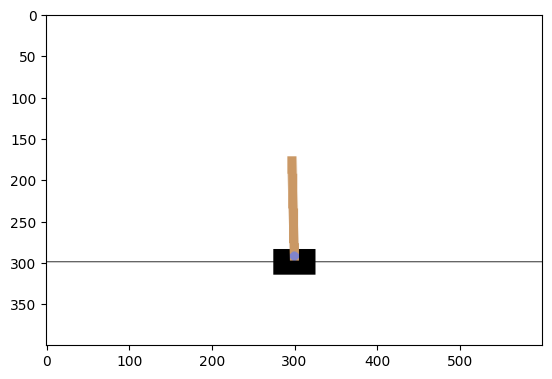

action=0, total_reward=1.0


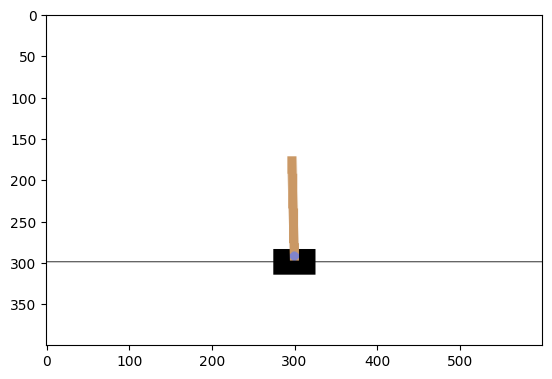

In [67]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
state, _ = env.reset()
done = False
total_reward = 0
state_image=env.render()
plt.imshow(state_image)
plt.show()

state_image=env.render()
action = model.predict(state[np.newaxis, :], verbose=False).argmax(axis=1)[0]
state, reward, done, _, _ = env.step(action)
total_reward += reward
print (f"{action=}, {total_reward=}")
state_image=env.render()
plt.imshow(state_image)
plt.show()

In [63]:
env = gym.make("CartPole-v1", render_mode="human")

state, _ = env.reset()
done = False
total_reward = 0

while not done and total_reward < 500:  # force end the game after 500 time steps because the model is too good!
    env.render()
    action = model.predict(state[np.newaxis, :], verbose=False).argmax(axis=1)[0]
    state, reward, done, _, _ = env.step(action)
    total_reward += reward

env.close()
print (f"{total_reward=}")

total_reward=96.0


In [53]:
env.close()

In [ ]:
## Discussion

### Changes in Model Definition

In this project, I used Docker to leverage GPU acceleration for the training process. 
However, even with the GPU, the original 1000 episodes defined in the starter code proved too computationally expensive 
to run within a reasonable time frame. To balance performance and efficiency, 
I reduced the number of episodes to 150, which resulted in **300 iterations** using the professors test configuration.

With this setup, I was able to achieve a reward of **95**. Altering the number of episodes or other parameters often led to smaller rewards. 
Occasionally, when running with the professors original hyperparameters, I observed the reward reaching up to **97**. 

### Epsilon Decay Changes

The original epsilon decay rate was set to **0.9975**, and convergence occurred around **990 episodes** in the original configuration. 
Given the reduction in the number of episodes in my configuration, I kept the epsilon decay at the same value. 
The decay behaved as expected, with exploration giving way to exploitation towards the end of training. 
This setup allowed me to achieve a reasonably high reward of 95.

### Gamma Changes

The original gamma value was set to **0.95**, representing a discount factor for future rewards. After testing multiple configurations, I decided to keep the gamma unchanged at **0.95**. Altering gamma, such as reducing it to **0.90**, led to a decrease in the final reward, dropping as low as **10**. This decrease in gamma likely caused the agent to prioritize immediate rewards over long-term gains, leading to poorer overall performance.

### Note:

This analysis is based on my own experiments and adjustments to the original starter code. The changes were necessary to adapt the project to run efficiently with GPU resources on Docker, but the results may differ slightly depending on hardware and environmental factors. A fellow student's report indicated that with a similar setup, but using cloud resources, they were able to increase the reward by adjusting the number of episodes and hyperparameters. Their highest reward was **17** with 30 episodes, demonstrating that hyperparameter tuning plays a significant role in the results.
